In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False

In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver

from transforms import transforms
from Decon import SpectralDecon

from TemperatureEstimates import TempEst_analytical
from TemperatureEstimates import TempEst_analytical_arr

In [153]:
def NDCT(t,s):
    N = len(t)
    dt = np.mean(np.diff(t))
    j_arr = np.fft.fftfreq(2*N, dt)[:(2*N)//2]
    
    D = np.cos(np.outer(2*np.pi*j_arr,(t + 1/(2*len(t)))))
    
    F = 2*D.dot(s)
    F[0] = F[0] * np.sqrt(1/(4*N))
    F[1:] = F[1:] * np.sqrt(1/(2*N))
    return j_arr, F

def fct(x):
    f = np.sin(2*np.pi*x*2) + np.cos(2*np.pi*x)# + np.random.random(len(x))
    return f


c = np.linspace(0,10,270) + np.random.uniform(-0.005,0.005, 270)
a = fct(c)

j, F = NDCT(c,a)

c2 = np.linspace(0,10,270)
yDCT = sp.fft.dct(a, type=2, norm='ortho', n = len(c2))


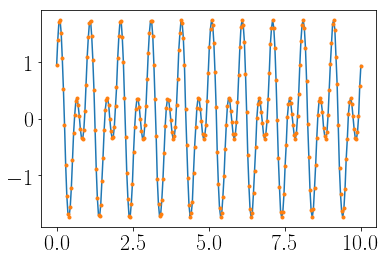

In [154]:
plt.plot(c2,a)
plt.plot(c,a,'.')

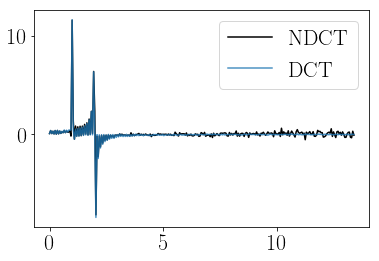

In [155]:
plt.plot(j,F,'k', label='NDCT')
plt.plot(j,yDCT, label='DCT', alpha=0.8)

#plt.xlim((0,10))
plt.legend()

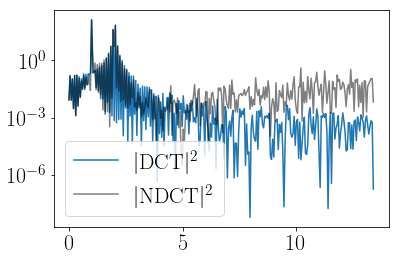

In [156]:
plt.semilogy(j,abs(yDCT)**2, label='$|$DCT$|^2$')
plt.semilogy(j,abs(F)**2,'k',label='$|$NDCT$|^2$',alpha=0.5)
#plt.xlim(0,10)
plt.legend()

[0.04  0.039 0.04  0.04  0.039 0.04  0.039 0.04  0.039 0.04  0.04  0.039
 0.04  0.039 0.04  0.039 0.04  0.039 0.04  0.039 0.04  0.039 0.04  0.039
 0.04  0.039 0.04  0.039 0.039 0.04  0.039 0.04  0.039 0.04  0.039 0.039
 0.04  0.039 0.04  0.039 0.039 0.04  0.039 0.039 0.04  0.039 0.039 0.04
 0.039 0.039 0.04  0.039 0.039 0.04  0.039 0.039 0.039 0.04  0.039 0.039
 0.039 0.04  0.039 0.039 0.039 0.04  0.039 0.039 0.039 0.039 0.04  0.039
 0.039 0.039 0.039 0.04  0.039 0.039 0.039 0.039 0.039 0.039 0.04  0.039
 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.04  0.039 0.039 0.039 0.039
 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039
 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039
 0.038 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.039 0.038 0.039
 0.039 0.039 0.039 0.039 0.038 0.039 0.039 0.039 0.039 0.039 0.038 0.039
 0.039 0.039 0.039 0.038 0.039 0.039 0.039 0.038 0.039 0.039 0.039 0.038
 0.039 0.039 0.039 0.038 0.039 0.039 0.038 0.039 0.0

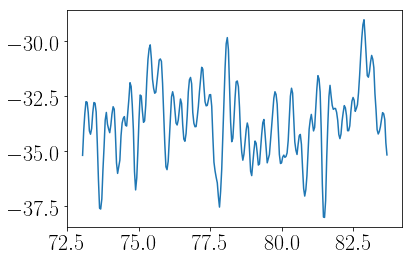

In [157]:
site = 'SiteB'
N_InInt = 32

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']

plt.plot(depth_LT,d18O_LT)
print(np.diff(depth_LT))

In [139]:
def NDCT(t,s):
    N = len(t)
    dt = np.mean(np.diff(t))
    j_arr = np.fft.fftfreq(2*N, dt)[:(2*N)//2]
    
    D = np.cos(np.outer(2*np.pi*j_arr,(t + 1/(2*len(t)))))
    
    F = 2*D.dot(s)
    F[0] = F[0] * np.sqrt(1/(4*N))
    F[1:] = F[1:] * np.sqrt(1/(2*N))
    return j_arr, F


In [158]:
x,y = NDCT(depth_LT,d18O_LT)
yDCT = sp.fft.dct(d18O_LT, type=2, norm='ortho', n = len(depth_LT))

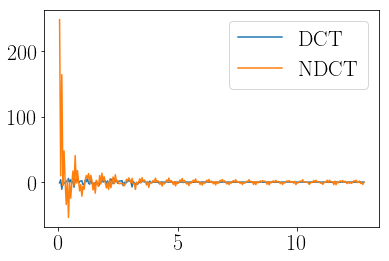

In [159]:
plt.plot(x[1:],yDCT[1:], label='DCT')
plt.plot(x[1:],y[1:], label='NDCT')
plt.legend()
#plt.gca().set(xlim=(-0.1,13), ylim=(-100,260));

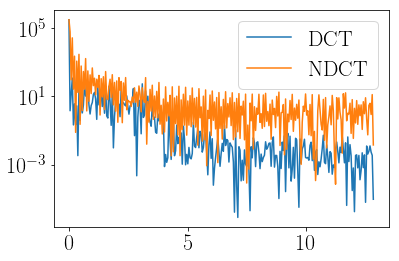

In [160]:
plt.semilogy(x,abs(yDCT)**2, label='DCT')
plt.semilogy(x,abs(y)**2, label='NDCT')
plt.legend()